In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from sdrudp.resample import resample

We inject a tone with known frequency $\nu$. If the sampling rate of the ADC $f_s^{\rm ADC}$ differs from the desired (master) sampling rate $f_s$, there will be a phase difference:

$$V(t) = e^{i2\pi\nu t},\, V_{\rm ADC}(t) = e^{i2\pi\nu t_{\rm ADC}} \\
e^{i \phi} = V_{\rm ADC}V^* = e^{i2\pi\nu (t_{\rm ADC}-t)} \\
\phi = 2\pi\nu (t_{\rm ADC}-t) = 2\pi\nu t \left(\frac{f_s}{f_s^{\rm ADC}} - 1\right)$$

If we measure the phase at two different times, $t_1$ and $t_2$, the phase difference is given by:
$$\Delta \phi = \phi(t_2) - \phi(t_1) = 2\pi\nu (t_2-t_1) \left(\frac{f_s}{f_s^{\rm ADC}} - 1\right) = 2\pi\nu \Delta t \left(\frac{f_s}{f_s^{\rm ADC}} - 1\right)$$

In particular, for successive time steps, $\Delta t = 1/f_s$:
$$\Delta \phi = \frac{2\pi\nu}{f_s} \left(\frac{f_s}{f_s^{\rm ADC}} - 1\right) \\
\frac{f_s \Delta \phi}{2\pi\nu} = \frac{f_s}{f_s^{\rm ADC}} - 1\ \\
f_s^{\rm ADC}= f_s \frac{2\pi\nu}{2\pi\nu + f_s\Delta \phi}$$

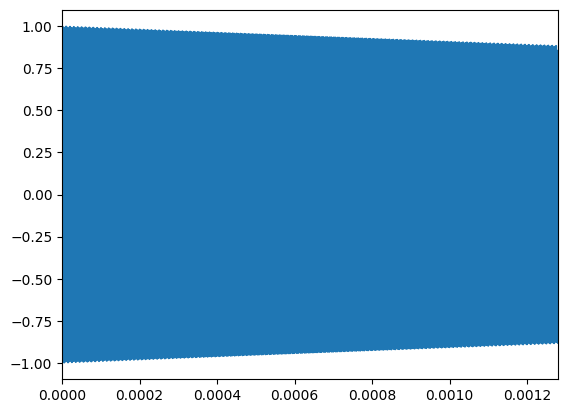

In [3]:
NSAMPLES = 4096
TONE = 901.5e6
LO = 901e6
SAMPLE_RATE = 3.2e6
t = np.arange(NSAMPLES) / SAMPLE_RATE
omega = 2 * np.pi * (TONE - LO)
tone_cos = np.cos(omega * t)
tone_sin = -np.sin(omega * t)  # conjugate

sample_fq = 3.200105e6
OFFSET = np.pi/3
re = np.cos(omega * t * SAMPLE_RATE / sample_fq + OFFSET)
im = np.sin(omega * t * SAMPLE_RATE / sample_fq + OFFSET)
data = np.array([re, im]).T
data = np.expand_dims(data, axis=0)  # add block axis (with nblocks=1)

plt.figure()
plt.plot(t, tone_cos-re)
plt.xlim(t.min(), t.max())
plt.show()

In [9]:
def phase(real, imag, tone_cos, tone_sin):
    """
    Compute phase difference between data and tone
    """
    data_cos = real * tone_cos - imag * tone_sin  # real part (real*real - im*im)
    data_sin = real * tone_sin + imag * tone_cos  # imaginary (real*im + im*real)
    dphi = np.arctan2(data_sin, data_cos) # phase difference in units of radians
    return dphi

In [10]:
data = data - np.mean(data, axis=1, keepdims=True)  # remove DC offset
real = data[0, :, 0]
imag = data[0, :, 1]
phi = phase(real, imag, tone_cos, tone_sin)

# recover the ADC sample rate
dphi = np.mean(np.diff(phi))
sample_ADC = SAMPLE_RATE * omega  / (omega + SAMPLE_RATE * dphi)
print(sample_ADC / sample_fq)  # how close we are to the true ADC sampling rate

0.999999991023093


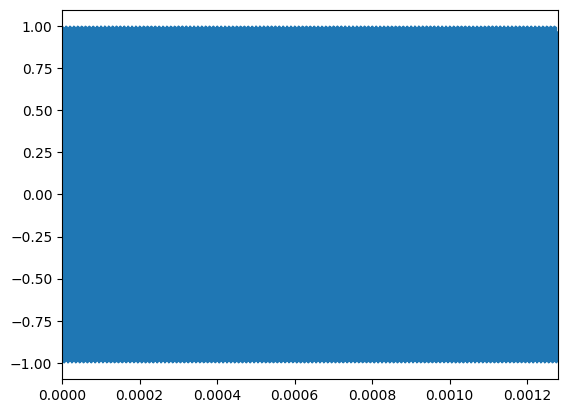

In [11]:
resamp_real, resamp_imag = resample(np.array([real, imag]), sample_ADC, SAMPLE_RATE)

plt.figure()
plt.plot(t, tone_cos - resamp_real)
plt.xlim(t.min(), t.max())
plt.show()

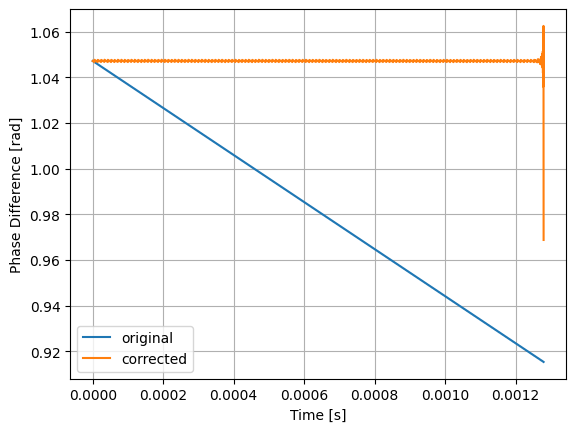

In [12]:
rs_cos = resamp_real * tone_cos - resamp_imag * tone_sin
rs_sin = resamp_real * tone_sin + resamp_imag * tone_cos
rs_phi = np.arctan2(rs_sin, rs_cos)

plt.figure()
plt.plot(t, phi, label="original")
plt.plot(t, rs_phi, label="corrected")
plt.ylabel("Phase Difference [rad]")
plt.xlabel("Time [s]")
plt.legend()
plt.grid()
plt.show()

## Real data: 2048 samples

In [13]:
d = np.load("../data/data_0403.npz")  #XXX keys have changed names for later files
data = d["data"][1:, 0]
rs_data = d["rs_data"][1:]
phi = d["dphi"][1:]
rs_phi = d["rs_dphi"][1:]


NSAMPLES = d["nsamples"][()]
TONE = d["tone"][()]
LO = d["lo"][()]
SAMPLE_RATE = d["sample_rate"][()]
t = np.arange(NSAMPLES) / SAMPLE_RATE
omega = 2 * np.pi * (TONE - LO)
tone_cos = np.cos(omega * t)
tone_sin = -np.sin(omega * t)  # conjugate

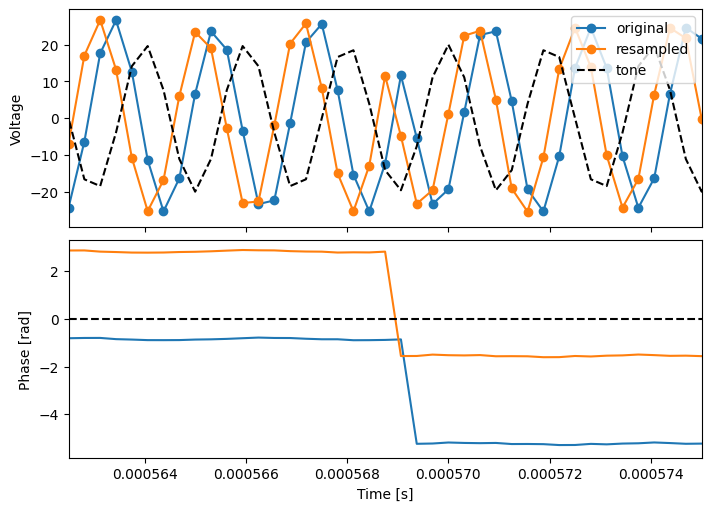

In [17]:
fig, axs = plt.subplots(figsize=(7, 5), nrows=2, sharex=True, constrained_layout=True)
axs[0].plot(t, data[0, :, 0], label="original", marker="o")
axs[0].plot(t, rs_data[0, :, 0], label="resampled", marker="o")
axs[0].plot(t, 20*tone_cos, label="tone", c="k", ls="--")
axs[0].set_ylabel("Voltage")
axs[0].legend(loc="upper right")
axs[1].plot(t, -phi[0])
axs[1].plot(t, rs_phi[0])
axs[1].axhline(0, c="k", ls="--")
axs[1].set_ylabel("Phase [rad]")
axs[1].set_xlabel("Time [s]")
plt.setp(axs, xlim=(t[1800], t[1840]))
plt.show()

104 / 391
0.05333626587908369


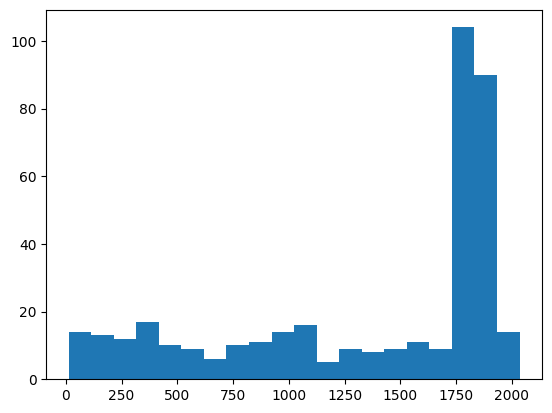

In [19]:
diff = np.abs(np.diff(np.unwrap(phi), axis=1))
m = diff.max(axis=1)
argm = diff.argmax(axis=1)
ix = m.argsort()[0]
print(np.count_nonzero(m < 5*diff.mean(axis=1)), "/", len(data))
print(m[ix])

plt.figure()
plt.hist(argm, bins=20, histtype="bar")
plt.show()

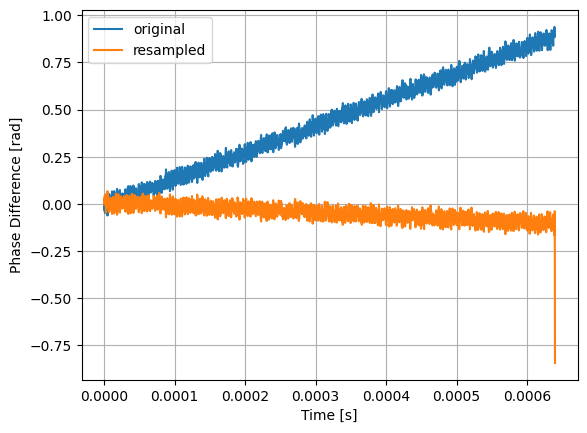

In [21]:
plt.figure()
plt.plot(t, phi[ix], label="original")
plt.plot(t, rs_phi[ix]-rs_phi[ix, 0], label="resampled")
plt.ylabel("Phase Difference [rad]")
plt.xlabel("Time [s]")
plt.legend()
plt.grid()
plt.show()

## 1024 samples (avoids discontinuity)

In [22]:
d = np.load("../data/data_0404.npz")  #XXX keys are changed in newer files
data = d["data"][1:, 0]
rs_data = d["rs_data"][1:]
phi = d["dphi"][1:]
rs_phi = d["rs_dphi"][1:]

NSAMPLES = d["nsamples"][()]
TONE = d["tone"][()]
LO = d["lo"][()]
SAMPLE_RATE = d["sample_rate"][()]
t = np.arange(NSAMPLES) / SAMPLE_RATE
omega = 2 * np.pi * (TONE - LO)
tone_cos = np.cos(omega * t)
tone_sin = -np.sin(omega * t)  # conjugate

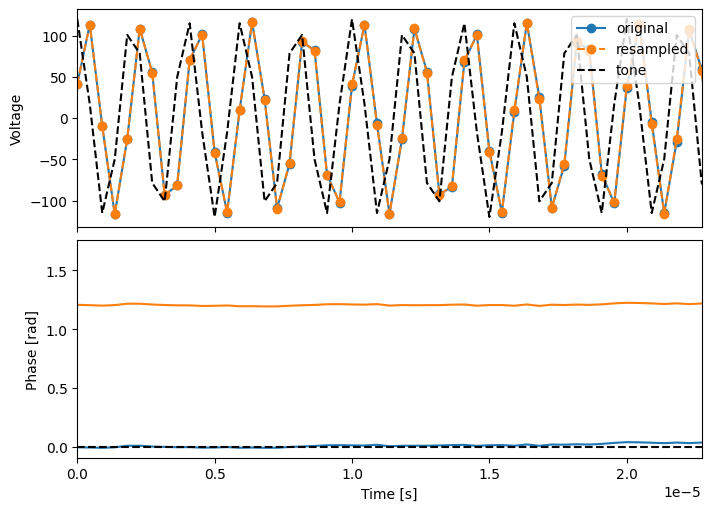

In [24]:
fig, axs = plt.subplots(figsize=(7, 5), nrows=2, sharex=True, constrained_layout=True)
axs[0].plot(t, data[0, :, 0], label="original", marker="o")
axs[0].plot(t, rs_data[0, :, 0], label="resampled", marker="o", ls="--")
axs[0].plot(t, 120*tone_cos, label="tone", c="k", ls="--")
axs[0].set_ylabel("Voltage")
axs[0].legend(loc="upper right")
axs[1].plot(t, phi[0])
axs[1].plot(t, rs_phi[0])
axs[1].axhline(0, c="k", ls="--")
axs[1].set_ylabel("Phase [rad]")
axs[1].set_xlabel("Time [s]")
plt.setp(axs, xlim=(t[0], t[50]))
plt.show()

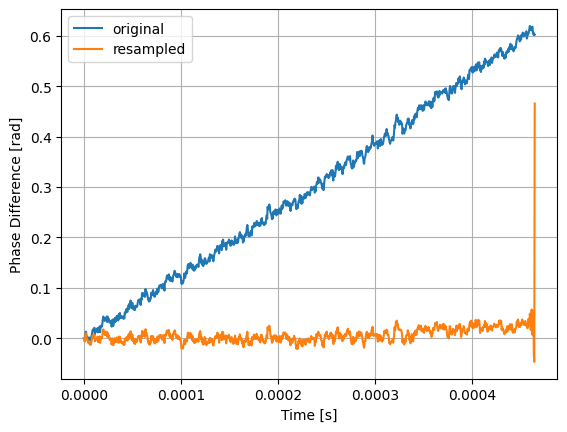

In [25]:
ix = 0
plt.figure()
plt.plot(t, phi[ix], label="original")
plt.plot(t, rs_phi[ix]-rs_phi[ix, 0], label="resampled")
plt.ylabel("Phase Difference [rad]")
plt.xlabel("Time [s]")
plt.legend()
plt.grid()
plt.show()

### Is it stable with time?

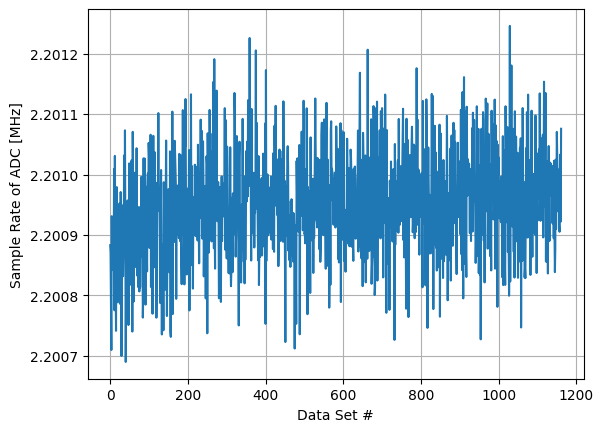

In [26]:
sr_adc = d["sample_adc"][1:]
plt.figure()
plt.plot(sr_adc / 1e6)
plt.ylabel("Sample Rate of ADC [MHz]")
plt.xlabel("Data Set #")
plt.grid()
plt.show()

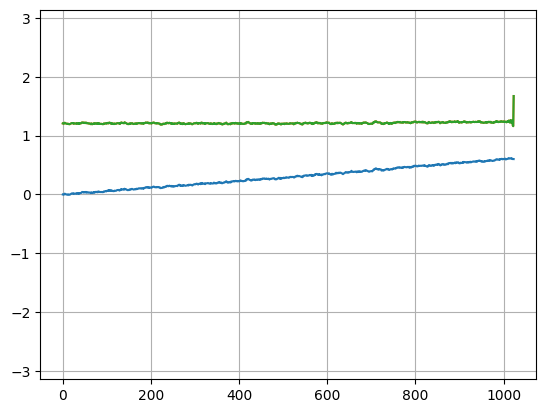

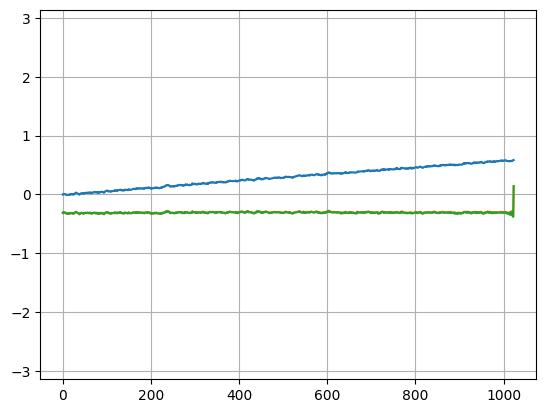

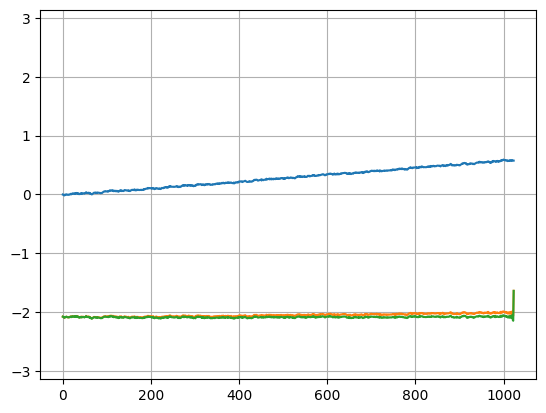

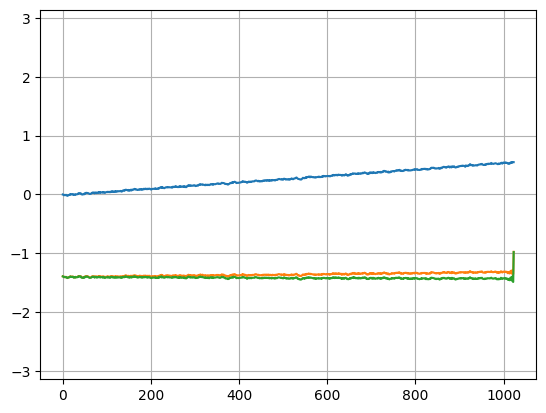

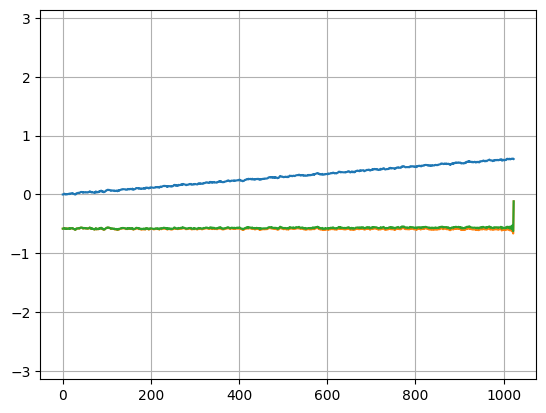

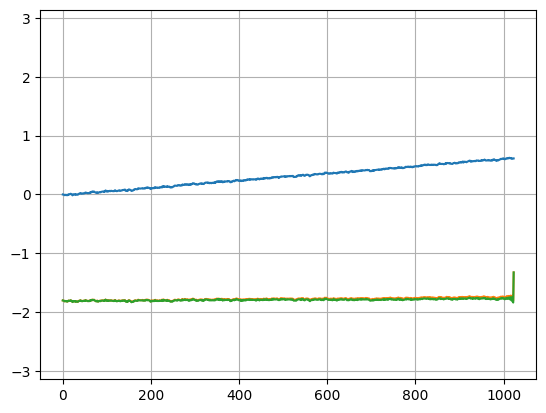

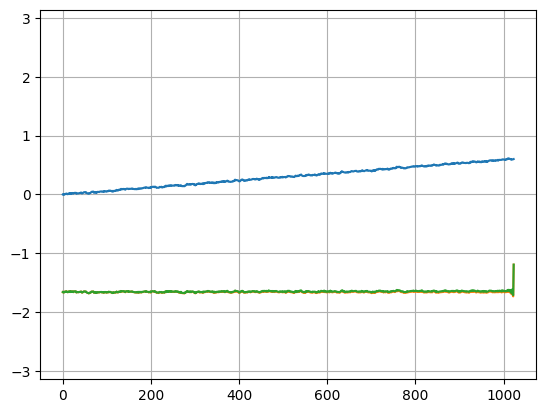

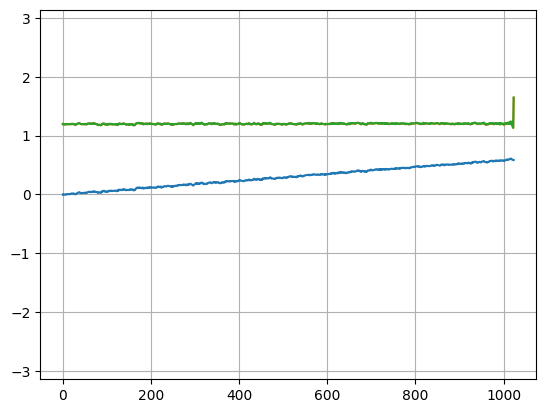

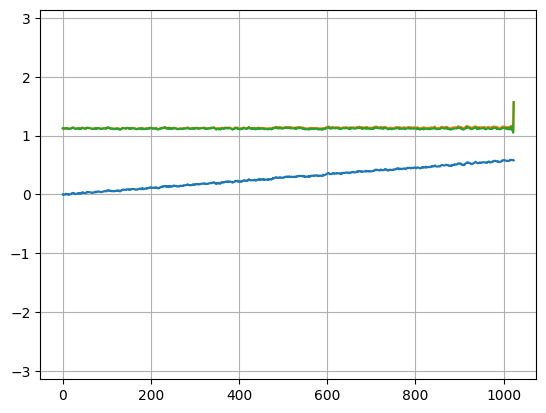

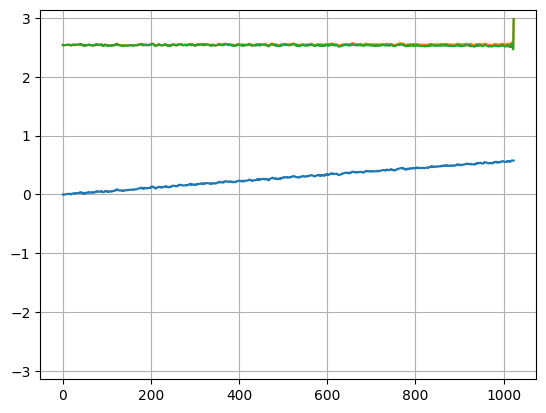

In [28]:
f_in = sr_adc[ix]

resamp_real = resample(data[:, :, 0], f_in, SAMPLE_RATE)
resamp_imag = resample(data[:, :, 1], f_in, SAMPLE_RATE)
ph = phase(resamp_real, resamp_imag, tone_cos, tone_sin)
for i in range(10):
    plt.figure()
    plt.plot(phi[i])
    plt.plot(rs_phi[i])
    plt.plot(-ph[i])
    plt.ylim(-np.pi, np.pi)
    plt.grid()
    plt.show()

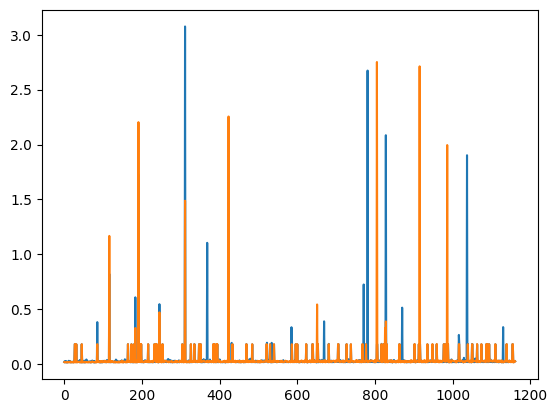

[0.04862727 0.04829386]
[0.02121839 0.0241793 ]
[3.07540405 2.75170184]


In [29]:
std = np.array([rs_phi.std(axis=1), ph.std(axis=1)])
plt.figure()
plt.plot(std.T)
plt.show()

print(np.mean(std, axis=1))
print(np.median(std, axis=1))
print(np.max(std, axis=1))